In [1]:
import math
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from pyswarm import pso

In [2]:
#### functions to transform 1-array into triangular inf matrix  and vice versa ####

def i2j_to_k(i, j):
    return i*(i-1)/2 + j


def k_to_i2j(k):
    i = int((1+math.sqrt(1+8*k))/2)
    j = int(k - i*(i-1)/2)
    return (i,j)
    

def d1_2_mat(d):
    l = len(d)
    (n, _) = k_to_i2j(l)
    #print(n)
    mat = np.zeros([n,n])
    for k in range(l):
            (i,j) = k_to_i2j(k)
            mat[i,j] = d[k]
            mat[j,i] = -d[k]
    return mat


def mat_2_d1(mat):
    
    (n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    liste = []
    for k in range(k_max):
        (i,j) = k_to_i2j(k)
        liste.append(mat[k_to_i2j(k)])
        
    return np.array(liste)


def d1_2_mat_list(d, n_Item):
    
    item_list = np.reshape(np.array(d), (n_Item, -1))
    l = len(item_list[0])
    
    (n, _) = k_to_i2j(l)

    mat = np.zeros([n_Item,n,n])
    
    for it in range(n_Item):

        for k in range(l):
                (i,j) = k_to_i2j(k)
                mat[it,i,j] = item_list[it,k]
                mat[it,j,i] = -item_list[it,k]
    return mat


def mat_2_d1_list(mat):
    
    liste_totale = []
    (n_item, n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    for it in range(n_item):
        liste = []
        for k in range(k_max):
            (i,j) = k_to_i2j(k)
            liste.append(mat[it,i,j])
            
        liste_totale+= liste

    return np.array(liste_totale)    

In [3]:
def detection_cooperation_old(env, id_agent_source, last_offer): #ratio other agent gave / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    if len(history) < 2:
        return np.zeros(n_agents)
    else:
        last_trans = history[-2].sum(1) #what each agent gave
        #last_offer = agent.last_offers[-1]
        my_offer_max = np.sum(np.maximum(last_offer,0))
        
        #print("last_trans", last_trans)
        
        coop_degrees = np.clip(last_trans/my_offer_max,0,1)
    
        return coop_degrees

In [4]:
def detection_cooperation(env, id_agent_source, last_offer): #ratio other agent gave ME * (N_agent-1) / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    if len(history) < 2:
        return np.zeros(n_agents)
    else:        
        # history[-1] is the history location for the current step
        # history[-2] is the history location for the previous step
        last_trans = history[-2][:, id_agent_source] * (n_agents - 1) #what each agent gave
        my_offer_max = np.sum(np.maximum(last_offer, 0))
        
        #print("last_trans", last_trans)
        #print("my_offer_max", my_offer_max)
        
        coop_degrees = np.clip(last_trans/my_offer_max, 0, 1)
    
        return coop_degrees

In [5]:
last_trans = np.array([0.0, 0.5, 0.9])
my_offer_max = np.array([0.0, -0.6, 0.9])
np.clip(last_trans/my_offer_max, 0, 1)

/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([nan,  0.,  1.])

In [6]:
def TFT(alpha, r, beta=0):
    def function(old_coop_degrees, detected_coop_degrees, r):
        delta = detected_coop_degrees - old_coop_degrees
        r = np.maximum(r + beta*delta, 0)
        output = alpha*old_coop_degrees + (1-alpha)*(r + (1-r)*detected_coop_degrees)        
        return output, r
        
    return function, r

In [7]:
class Agent:
    def __init__(self, id_agent, n_agents, n_items, neg_algo=0):
        self.n_agents = n_agents
        self.n_items = n_items
        self.id_agent = id_agent
        self.old_coop_degrees = np.zeros(self.n_agents)
        self.ut_function = []
        self.last_offers = []
        tft_algo, r = neg_algo
        self.negociation_algo =  tft_algo
        self.r = r*np.ones(self.n_agents)
        
    def coop_detection(self, env):
        n_agents = env.n_agents
        id_agent_source = self.id_agent
        if len(self.last_offers) == 0:
            return np.zeros(n_agents)
            #print("no last offer")
        else:
            #print("presence last offers")
            last_offer = self.last_offers[-1]
            output = detection_cooperation(env, id_agent_source, last_offer)
            return output 
        
    def offer(self, env):
        tran= env.optimize_localy(self.id_agent)
        self.last_offers.append(tran)
        return tran
    
    def negociation(self, detected_coop_degrees):
        output, r_new = self.negociation_algo(self.old_coop_degrees, detected_coop_degrees, self.r)
        self.r = r_new
        self.old_coop_degrees = output
        return output

In [8]:
class Environment:
    def __init__(self, n_agents, n_items, list_agents = []):
        self.n_agents = n_agents
        self.agents = list_agents
        self.n_items = n_items
        self.t = 0 #step 
        self.state = np.zeros([n_agents, n_items])
        self.states_history = [] #history of states
        self.transactions_history = []
        self.transactions_history_numpy = []
        
        self.optimal_SW = 0 #optimal social welfare 
        self.hist_SW = [] #evolution of social welfare
        self.hist_ut_agents = [[] for _ in range(self.n_agents)] #evolution of utilities of agents 
        
        self.hist_coop_degrees = [] #evolution of cooperation degrees
        
        
    def init_state(self, state):
        s = np.copy(state)
        self.state = s
        self.t = 0
        
    def next_round(self):
        self.t += 1
        self.transactions_history.append([])
        self.transactions_history_numpy.append(np.zeros([env.n_agents, env.n_agents]))
        
    def replace_agents(self, list_agents):
        self.agents = list_agents
        
    def clip_state(self, lb, ub):
        self.state = np.clip(self.state, lb, ub)
    
    def random_init(self, mean=0, std=1):
        self.state = np.random.normal(mean, std, size = [self.n_agents, self.n_items])
        
    def transaction(self, id_agent_source, id_agent_target, id_item, quantity):
        self.state[id_agent_target, id_item] += quantity
        self.state[id_agent_source, id_item] -= quantity
        
        self.transactions_history[-1].append((env.t, id_agent_source, id_agent_target, id_item, quantity))
        
        #update quantities shared between agents (independently of items)
        self.transactions_history_numpy[-1][id_agent_source, id_agent_target] += quantity
        
        
        
    def add_transactions_np(self, state, transactions):
        #state : array nA x nI
        #transactions : array nI x nA x nA

        (nA, nI) = np.shape(state)
        new_s = state.copy()
        for item in range(nI):
            for agent in range(nA):
                new_s[agent, item] -= transactions[item, agent, : ].sum()

        return new_s
    
    def add_transactions_var(self, state, trans_var):
        #state : array nA x nI
        #trans_var : variable for optimisation, liste
        transactions = d1_2_mat_list(trans_var, self.n_items)
        return self.add_transactions_np(state, transactions)
    

    def global_utility(self, state, lb =-2.0, ub = 100.0):
        s = np.copy(state)
        s = np.clip(s, lb, ub)
        return -np.log(s+2+1e-8).sum()
    
    def local_utility(self, state, id_agent):
        s = np.copy(state)
        s = s[id_agent,:]
        s = np.clip(s, -2, 100)
        return -np.log(s+2+1e-8).sum()
    
    def optimize_localy(self, id_agent, lb = -4, ub = 4, min_cons = -1):
        (nA, nI) = self.n_agents, self.n_items
        size_var = nI #size of variable 
        lb_list = lb*np.ones(size_var) #lower bounds
        ub_list = ub*np.ones(size_var) #upper bounds
        
        s_tmp = np.copy(self.state)
        
        def f_opt(dx): #utility function for pso
            s = np.copy(s_tmp)
            s[id_agent, :] += dx
            return self.local_utility(s, id_agent) + 0.01 * np.linalg.norm(dx)
            
        def constraint(dx):
            s = np.copy(s_tmp)
            s[id_agent, :] += dx       
            s = s[id_agent]        
            const_out1 = s-min_cons
            const_out2 = np.array([-dx.sum()])
            const_out = np.concatenate((const_out1,const_out2))

            return const_out
        
        xopt, fopt = pso(f_opt, f_ieqcons= constraint, lb=lb_list, ub=ub_list, maxiter=200, swarmsize=200)
        
        return(xopt)
    
    
    def optimize_globally(self, lb = -2.0, ub = 2.0):
        (nA, nI) = self.n_agents, self.n_items
        k_max = nI * ( int((nA-1)*(nA-2)/2 + nA-1)  )
        d_var = np.zeros(k_max)
        lb_list = lb*np.ones(k_max)
        ub_list = ub*np.ones(k_max)
        
        s = self.state.copy()
        
        def f_opt(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            fusion_items = trans_var_np.sum(0)
            received_agents = fusion_items.sum(1)
            
            return self.global_utility(new_s_tmp) + 0.1*np.linalg.norm(received_agents) + 0.1 * np.linalg.norm(dx) 
    
        def constraint(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            const_out = new_s_tmp - min_cons
            #const_out2 = np.array([-dx.sum()])
            #const_out = np.concatenate((const_out1,const_out2))

            return const_out
    
        xopt, fopt = pso(f_opt, lb_list, ub_list, maxiter=300, swarmsize=300)
        
        transactions = d1_2_mat_list(xopt, self.n_items)
        new_s = self.add_transactions_np(s, transactions)
        #print(new_s)
        
        return(transactions, new_s, env.global_utility(new_s))
        
    def optimal_social_welfare(self):
        (transactions, new_s, fopt) = self.optimize_globally()
        self.optimal_SW = fopt
        return fopt
        
    def get_observation(self, id_agent):
        return self.state[id_agent, :]
    
    
    def allocation(self, coop_degrees, demands):
        
        # demands greater than zero correspond to demands
        agents_demands = np.maximum(demands, 0)
        
        # demands lower than zero correspond to offers
        agents_offers = -np.minimum(demands, 0)
        
        print('agents_demands\n', agents_demands)
        print('agents_offers\n', agents_offers)
        for it in range(self.n_items):
            for agent_source in range(self.n_agents):
                source_offer = agents_offers[agent_source, it]
                
                if source_offer > 0: #agent_source can give source_offer for item it
                    demands_targets = np.zeros([self.n_agents])
                    parts_targets = np.zeros([self.n_agents])  
                    
                    for agent_target in range(self.n_agents):
                        target_demand = agents_demands[agent_target, it] #demand of agent_target if < 0
                        target_demand_clip = min(target_demand, source_offer)
                        demands_targets[agent_target] = target_demand_clip
                        parts_targets[agent_target] = target_demand_clip
                    total_demand = demands_targets.sum()

                    for agent_target in range(self.n_agents):
                        alloc = demands_targets[agent_target]*coop_degrees[agent_source, agent_target]*source_offer 
                        if total_demand != 0:
                            alloc /= total_demand
                        alloc = min(alloc, source_offer)
                        
                        self.transaction(agent_source, agent_target, it, alloc)


    def show(self):
        fig, axs = plt.subplots(1, self.n_agents)
        for i in range(self.n_agents):
            axs[i].bar(np.arange(self.n_items),self.get_observation(i), orientation = 'vertical')
            axs[i].axis('equal')
            axs[i].set_title('Agent ' + str(i+1) + ' at step' + str(self.t))
            axs[i].set_ylim([-1,1])

#env = Environment(3,4, liste_agents_A)     

In [9]:
algo2 = TFT(0.1, 0.2, 0.7)
algo1 = TFT(0.2, 0.1, 0.6)
egoist = TFT(1, 0, 0.5)

n_agents = 3
n_items = 3
a1 = Agent(0, n_agents, n_items, algo1)
a2 = Agent(1, n_agents, n_items, algo1)
a3 = Agent(2, n_agents, n_items, algo1)
#a4 = Agent(3, n_agents, n_items, algo1)

liste_agents_A = [a1, a2, a3]

In [10]:
state_B = np.array([
    [-1.0,2.0,0.0,1.0],
    [3.0,1.0,-1.0,1.0],
    [1.0,-1.0,3.0,1.0],
    
])

state_C = np.array([
    [0.0,2.0,0.0,1.0,-1.0,1.0],
    [2.0,2.0,-1.0,1.0,-1.0,0.0],
    [1.0,-1.0,1.0,-1.0,2.0,1.0],
    
])

state_D = np.array([
    [-1.0,  1.0,  0.0,  1.0, -1.0,  1.0],
    [-1.0,  1.0, -1.0,  1.0, -1.0,  0.0],
    [ 1.0, -1.0,  1.0, -1.0,  1.0,  1.0],
    [-1.0,    0,  1.0, -1.0, -1.0,  1.0],
    
])

state_E = np.array(
    [
        [-1.,  2.,  2.],
        [ 2.,  2., -1.],
        [ 2., -1.,  2.]
    ])

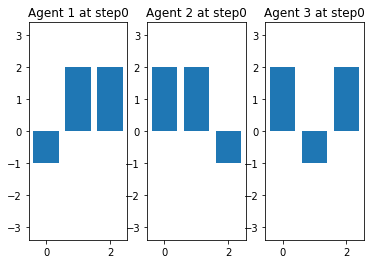

In [11]:
n_agents = 3
n_items = 3
env = Environment(n_agents, n_items, liste_agents_A) 
env.init_state(state_E)
#env.init_state(new_s)
env.show()

[]


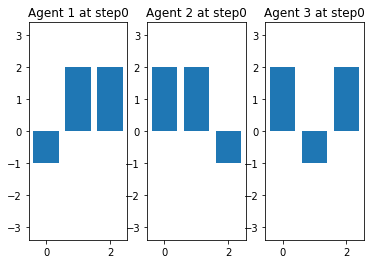

In [12]:
env.show()
print(env.hist_SW)

In [13]:
def episode(env):
    n_agents = env.n_agents
    n_items = env.n_items
    opt_sw = env.optimal_social_welfare()
    print('opt_sw:', opt_sw)
    env.next_round()
    
    env.states_history.append(env.state)
    current_SW = env.global_utility(env.state)
    env.hist_SW.append(current_SW)
    
    for i_A in range(n_agents):
        uti_agent = env.local_utility(env.state, i_A)
        env.hist_ut_agents[i_A].append(uti_agent)
    
    env.show()

        
    
    demands = np.zeros([n_agents, n_items])
    
    
    coop_degrees = np.zeros([n_agents, n_agents])
    
    for i_agent in range(n_agents):
        transa = env.agents[i_agent].offer(env)
        env.agents[i_agent].last_offers.append(transa)
        #print(transa)
        
        print("Agent ",i_agent)
        coop_deg_detected = env.agents[i_agent].coop_detection(env)
        print("coop deg detected ", coop_deg_detected)
        
        coop_deg_i = env.agents[i_agent].negociation(coop_deg_detected)
        print("coop deg negociated ", coop_deg_i)
        print()
        
        
        demands[i_agent, : ] = transa
        coop_degrees[i_agent,:] = coop_deg_i
        
    coop_degrees = np.clip(coop_degrees,0,1)
    
    print('coop_degrees:\n', coop_degrees)
    env.hist_coop_degrees.append(coop_degrees)
    
    print('demands:\n', demands)
    env.allocation(coop_degrees, demands)
    #print(np.sum(env.state, axis=1))

In [14]:
def mean_coop_degrees(matrix_list):
    if matrix_list == []:
        return []
    else:
        (n_A,_) = np.shape(matrix_list[0])
        output = [ [[] for _ in range(n_A)], [[] for _ in range(n_A)] ]  #curves for mean receiving AND sending coop degree 
        for coop_degrees_mat in matrix_list:
            rece_coop = coop_degrees_mat.sum(0)
            send_coop = coop_degrees_mat.sum(1)
            for i_A in range(n_A):
                mean_rece = (rece_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[0][i_A].append(mean_rece)    #receiving coop degree mean for agent i_A

                mean_send = (send_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[1][i_A].append(mean_send)    #receiving coop degree mean for agent i_A

        return output

In [15]:
def figure_utilities(sw, list_ut, output_fig, max_t, lu=2,uu=4):
    colors = ['b','m','c','r']
    t_max = min(len(sw), max_t)
    t = np.arange(t_max)
    
    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize = 14)
    ax1.set_ylabel('Social Welfare', color='g', fontsize = 14)
    ax1.plot(t, sw[:t_max], color='g', label="Social Welfare")
    ax1.tick_params(axis='y', labelcolor='g', labelsize = 14)
    plt.legend(loc=2, fontsize=13)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Individual Utility', color=color, fontsize = 14) 
    ax2.set_ylim(lu, uu)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14)



    for i_A in range(len(list_ut)):
        color = colors[i_A]
        label = "Agent "+str(i_A+1)
        if i_A == 5:
            label = "Egoist"
        ax2.plot(t, list_ut[i_A][:t_max], color=color, label=label)
    
    plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [16]:
def figure_coop_degrees_mean(list_coop, output_fig, max_t, lc=0 ,uc=1):
    colors = ['b','m','c','g','r']
    
    t_max = min(len(list_coop[0][0]), max_t)
    t = np.arange(t_max)

    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize=14)
    ax1.set_ylabel('Mean Cooperation Degree',fontsize=14)

    ax1.set_ylim(lc, uc)

    ax1.tick_params(axis='y', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    


    for i_A in range(len(list_coop[0])):
        color = colors[i_A]
        if i_A != 5:
            label = "Agent "+str(i_A+1)
        else:
            label = "Egoist"
        ax1.plot(t, list_coop[0][i_A][:t_max], color, label = label + " : receiving")
        ax1.plot(t, list_coop[1][i_A][:t_max], color+"--", label = label + " : sending")
        plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [17]:
def affiche(env, output,lu,uu,lc,uc):
    y_A = env.hist_ut_agents[0]
    y_B = env.hist_ut_agents[1]
    y_C = env.hist_ut_agents[2]
    #y_D = env.hist_ut_agents[3]
    y = env.hist_SW

    y_A = [-x for x in y_A]
    y_B = [-x for x in y_B]
    y_C = [-x for x in y_C]
    #y_D = [-x for x in y_D]
    y = [-x for x in y]
    
    mean_coop_degrees_expe = mean_coop_degrees(env.hist_coop_degrees)
    
    figure_utilities(y, [y_A, y_B, y_C], 'evolution_utilities_'+output +'.svg',10, lu, uu)
    
    figure_coop_degrees_mean(mean_coop_degrees_expe, 'evolution_cooperation_'+output+'.svg',10, lc, uc)    

In [18]:
env = Environment(3, 3, liste_agents_A)
env.init_state(state_E)

In [19]:
def effiency(list_SW, SWopt):
    SW0 = list_SW[0]
    output = []
    
    for sw in list_SW:
        e = min((-sw+SW0)/(-SWopt+SW0), 1)
        output.append(e)
        
    return output

In [20]:
def speed(list_eff, T):
    final_efficiency = list_eff[-1]
    x = np.arange(T)    
    return metrics.auc(x, list_eff[:T])/(T*final_efficiency)

In [21]:
def analyse(state, beta, r, alpha, N_iter=10):
    algo = TFT(beta, r, alpha)
    egoist = TFT(1, 0, 0.5)

    # n_agents: number of actors, n_items: number of items
    n_agents, n_items = np.shape(state)
    
    T_speed = 10    
    T_speed = min(T_speed, N_iter)

    a1 = Agent(0, n_agents, n_items, algo)
    a2 = Agent(1, n_agents, n_items, algo)
    a3 = Agent(2, n_agents, n_items, algo)

    b1 = Agent(0, n_agents, n_items, algo)
    b2 = Agent(1, n_agents, n_items, algo)
    b3 = Agent(2, n_agents, n_items, egoist)
    
    c1 = Agent(0, n_agents, n_items, algo)
    c2 = Agent(1, n_agents, n_items, egoist)
    c3 = Agent(2, n_agents, n_items, egoist)

    agents_A = [a1, a2, a3]
    agents_B = [b1, b2, b3]
    agents_C = [c1, c2, c3]
    
    env_A = Environment(n_agents, n_items, agents_A)
    env_A.init_state(state)
    
    env_B = Environment(n_agents, n_items, agents_B)
    env_B.init_state(state)
    
    env_C = Environment(n_agents, n_items, agents_C)
    env_C.init_state(state)
    
    tra, ns, swopt = env_A.optimize_globally()
    
    for i_ep in range(N_iter):
        print("Env A, episode ", i_ep)
        episode(env_A)
        
    for i_ep in range(N_iter):
        print("Env B, episode ", i_ep)
        episode(env_B)
        
    for i_ep in range(N_iter):
        print("Env C, episode ", i_ep)
        episode(env_C)
            
    effic = effiency(env_A.hist_SW, swopt)
    
    ef = effic[-1]

    sp = speed(effic, T_speed)
    
    ut_max_pers_nices = -1 * env_A.hist_ut_agents[2][-1] #positive
    ut_pers_3egoist = -1 * env_A.hist_ut_agents[0][0] #positive  
    ut_pers_1egoist = -1 * env_B.hist_ut_agents[2][-1] #positive
    ut_pers_2egoist = -1 * env_C.hist_ut_agents[0][-1] #positive

    print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)
    
    ic = (ut_max_pers_nices-ut_pers_1egoist) / ut_max_pers_nices
    sf = (ut_pers_2egoist-ut_pers_3egoist)
    
    return [[beta, r, alpha], [env_A, env_B, env_C], ef, sp, ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist]

state:
 [[-1.  2.  2.]
 [ 2.  2. -1.]
 [ 2. -1.  2.]]
Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.873494961355316
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

coop_degrees:
 [[0.09 0.09 0.09]
 [0.09 0.09 0.09]
 [0.09 0.09 0.09]]
demands:
 [[ 1.94200589 -0.93477286 -1.00723356]
 [-0.95556145 -0.97968098  1.93524182]
 [-1.00035752  1.97204701 -0.97168975]]
agents_demands
 [[1.94200589 0.         0.        ]
 [0.         0.         1.93524182]
 [0.         1.97204701 0.        ]]
agents_offers
 [[-0.          0.9347728

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.2586349  0.26811312 0.        ]
coop deg negociated  [0.39921882 0.40690331 0.1       ]

coop_degrees:
 [[0.1        0.99977026 0.99975375]
 [0.99977583 0.1        0.99980382]
 [0.39921882 0.40690331 0.1       ]]
demands:
 [[ 0.00292466 -0.00174259 -0.00118226]
 [-0.00024087 -0.00232921  0.00257005]
 [-0.00908789  0.02103977 -0.01195188]]
agents_demands
 [[0.00292466 0.         0.        ]
 [0.         0.         0.00257005]
 [0.         0.02103977 0.        ]]
agents_offers
 [[-0.          0.00174259  0.00118226]
 [ 0.00024087  0.00232921 -0.        ]
 [ 0.00908789 -0.          0.01195188]]
Env A, episode  8
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.887031028832848
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.01336062 0.2012863 ]
coop deg negociated  [0.1        0.20079913 0.35301727]

Stopping search: Swarm

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.858707773388668
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.36983338 0.        ]
coop deg negociated  [0.0999999  0.43431587 0.0999999 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.40381838 0.         0.        ]
coop deg negociated  [0.46143183 0.0999999  0.0999999 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10416227 0.10938543 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.0999999  0.43431587 0.0999999 ]
 [0.46143183 0.0999999  0.0999999 ]
 [0.         0.         0.        ]]
demands:
 [[ 0.93472172 -0.69863077 -0.2360912 ]
 [-0.26185253 -0.66753435  0.92938687]
 [-0.66778482  1.37590824 -0.70812342]]
agents_demands
 [[0.93472172 0.         0.        ]
 [0.         0.         0.92938687]
 [0.         1.37590824 0.        ]]
agents_offers
 [

/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.09 0.09 0.09]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.89990025 -0.90884927 -0.99105194]
 [-0.95465616 -0.95497774  1.90960834]
 [-0.95702519  1.93359862 -0.97657347]]
agents_demands
 [[1.89990025 0.         0.        ]
 [0.         0.         1.90960834]
 [0.         1.93359862 0.        ]]
agents_offers
 [[-0.          0.90884927  0.99105194]
 [ 0.95465616  0.95497774 -0.        ]
 [ 0.95702519 -0.          0.97657347]]
Env C, episode  1
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.869185715516897
Stopping search: Swarm best objec

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.82046228512831
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.1 0.1 0.1]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.10704697 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10673006 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.1 0.1 0.1]
 [0.  0.  0. ]
 [0.  0.  0. ]]
demands:
 [[ 1.48082215 -0.75937964 -0.72144262]
 [-0.72034686 -0.72660499  1.44695184]
 [-0.74197278  1.45322825 -0.71125549]]
agents_demands
 [[1.48082215 0.         0.        ]
 [0.         0.         1.44695184]
 [0.         1.45322825 0.        ]]
agents_offers
 [[-0.          0.75937964  0.72144262]
 [ 0.72034686  0.72660499 -0.        ]
 [ 0.74197278 -0.          0.71125549]]
Env C, episode  

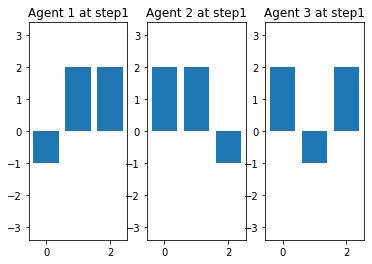

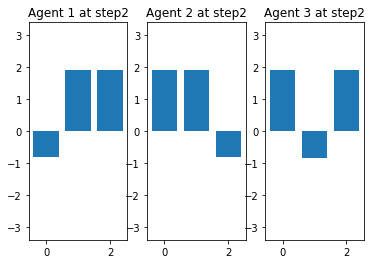

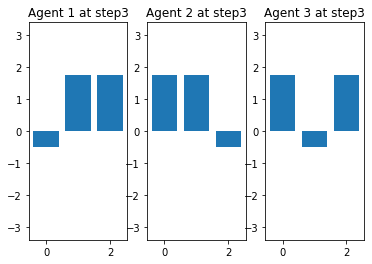

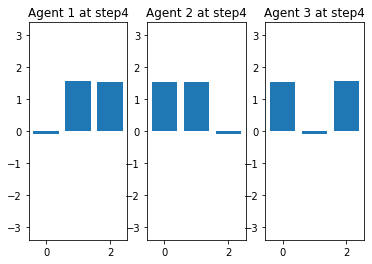

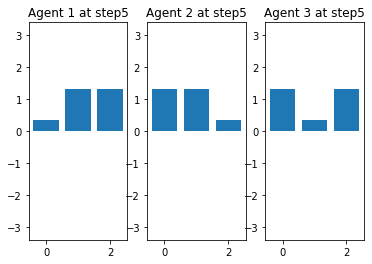

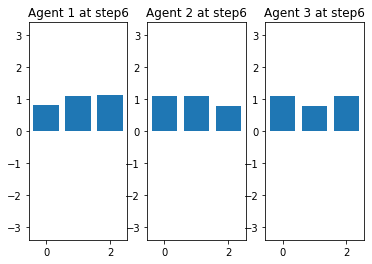

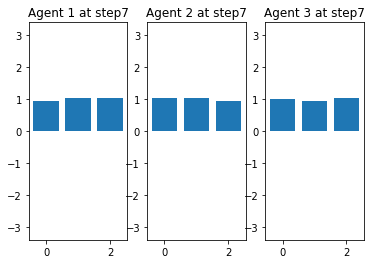

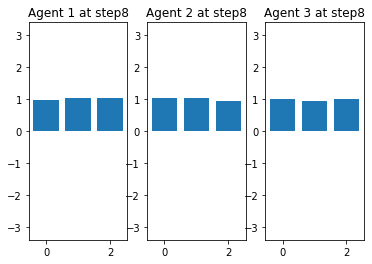

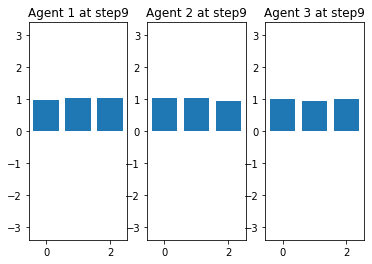

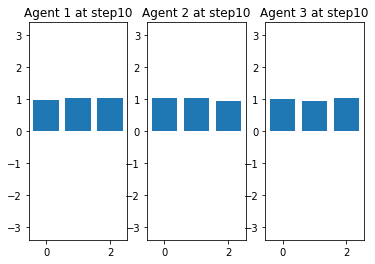

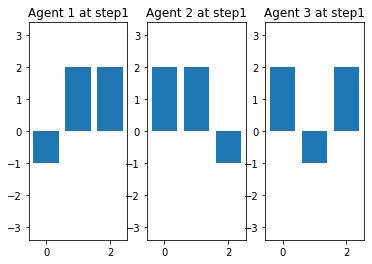

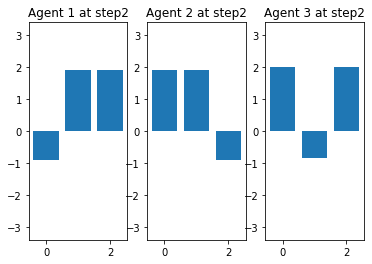

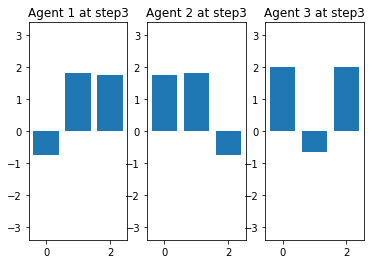

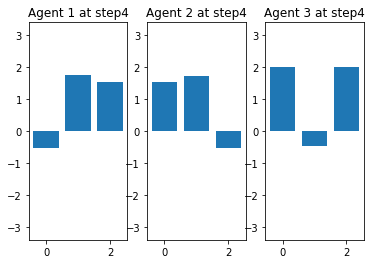

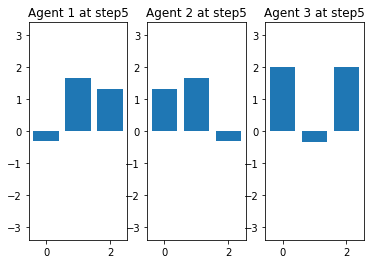

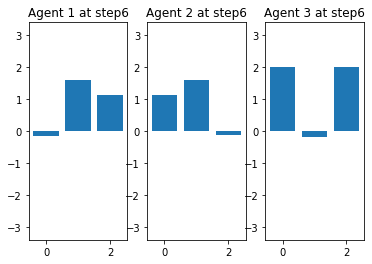

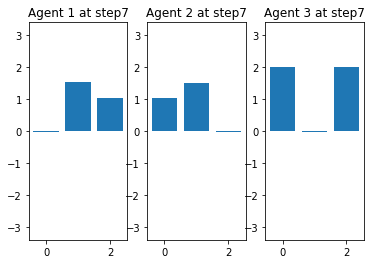

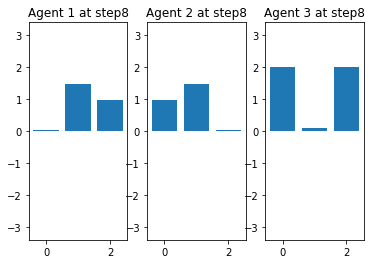

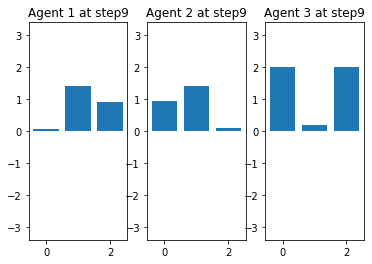

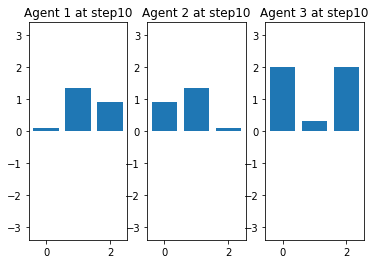

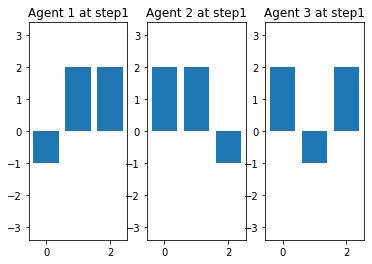

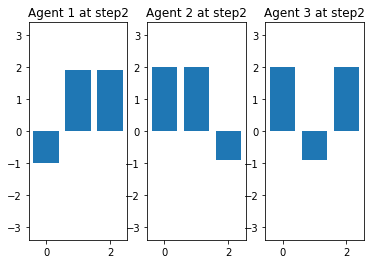

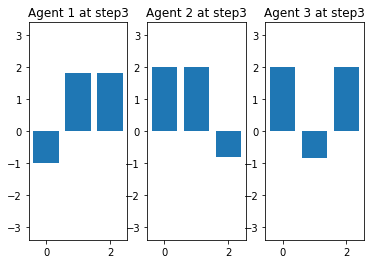

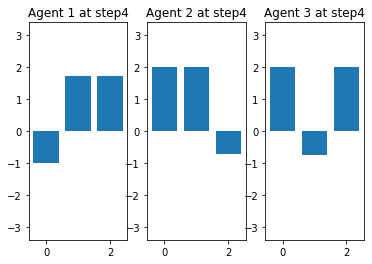

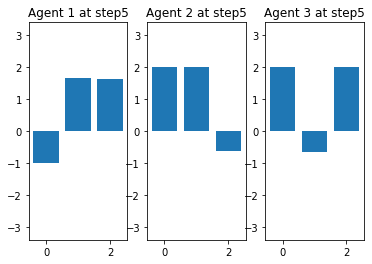

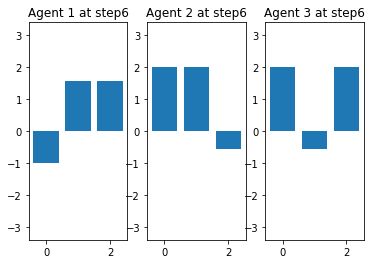

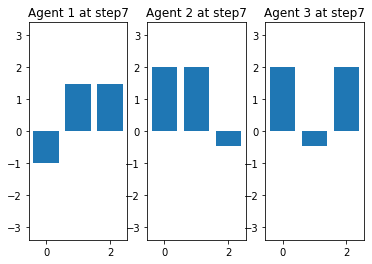

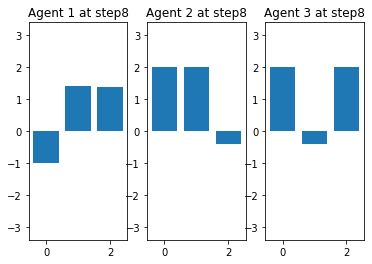

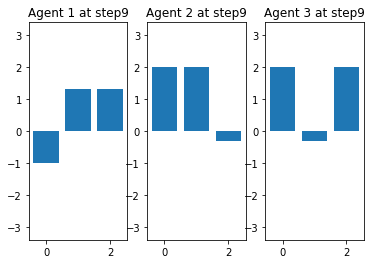

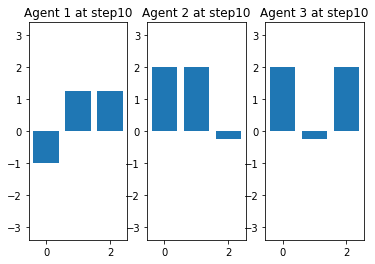

In [22]:
beta = 0.1
r = 0.1
alpha = 0
N_iter = 10
state = state_E
print('state:\n', state)
result = analyse(state, beta, r, alpha, N_iter)

In [23]:
env_D = result[1][0]
env_E = result[1][1]
env_F = result[1][2]

ut_max_pers_nices = -1 * env_D.hist_ut_agents[2][-1] #positive
ut_pers_3egoist = -1 * env_D.hist_ut_agents[0][0] #positive  
ut_pers_1egoist = -1 * env_E.hist_ut_agents[2][-1] #positive
ut_pers_2egoist = -1 * env_F.hist_ut_agents[0][-1] #positive

ic = ut_max_pers_nices-ut_pers_1egoist
sf = ut_pers_2egoist - ut_pers_3egoist

print(ic, sf)

print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)

-0.32201877271762314 -0.417808406644804
3.2849406299832182 3.6069594027008414 2.354780330594977 2.772588737239781


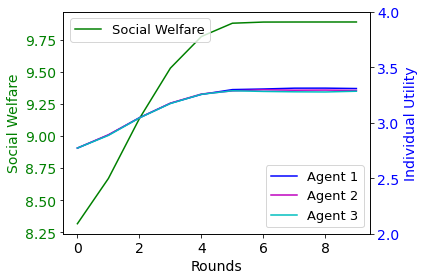

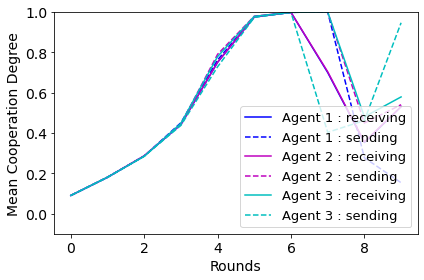

In [24]:
affiche(env_D, 'One_egoist', 2, 4, -0.1, 1)

In [25]:
def do_experiments(experiments):
    output = []
    for experiment in experiments:
        beta, r, alpha = experiment
        N_iter = 15
        a = analyse(state_E, beta, r, alpha, N_iter)
        output.append(a)
    
    return output

In [26]:
experiments = [
    # beta, r, alpha
    (0.1, 0.05, 0), 
    (0.1, 0.02, 0)
]

experiments_2 = [
    # beta, r, alpha
    (0.1, 0.05, 0),
    (0.1, 0.02, 0),
    (0.3, 0.1, 0),
    (0.5, 0.1, 0),
    (0.7, 0.1, 0),
    (0.1, 0.1, 0.3),
    (0.1, 0.1, 0.5),
    (0.1, 0.1, 0.7)
]

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.872835514074668
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

coop_degrees:
 [[0.045 0.045 0.045]
 [0.045 0.045 0.045]
 [0.045 0.045 0.045]]
demands:
 [[ 1.91981969 -0.96720701 -0.95261272]
 [-0.92652189 -0.99055302  1.91682694]
 [-0.94238627  1.89026617 -0.94788002]]
agents_demands
 [[1.91981969 0.         0.        ]
 [0.         0.         1.91682694]
 [0.         1.89026617 0.        ]]
agents_offers
 [[-0.          0.96720701  0.95261272]
 [ 0.92652189  0.9905

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.96637438 0.05       0.97214105]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.96188094 0.95741238 0.05      ]

coop_degrees:
 [[0.05       0.96910738 0.95913511]
 [0.96637438 0.05       0.97214105]
 [0.96188094 0.95741238 0.05      ]]
demands:
 [[ 0.19747944 -0.12922045 -0.06825899]
 [-0.06845381 -0.06797213  0.13642593]
 [-0.10552789  0.21934265 -0.11381486]]
agents_demands
 [[0.19747944 0.         0.        ]
 [0.         0.         0.13642593]
 [0.         0.21934265 0.        ]]
agents_offers
 [[-0.          0.12922045  0.06825899]
 [ 0.06845381  0.06797213 -0.        ]
 [ 0.10552789 -0.          0.11381486]]
Env A, episode  8
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.886320734839224
Stopping search: Swarm best objective change less than 1e-08
Agent  0


Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.875269144605259
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: maximum iterations reached --> 200
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.045 0.045 0.045]
 [0.045 0.045 0.045]
 [0.    0.    0.   ]]
demands:
 [[ 1.9252928  -0.9715705  -0.95372256]
 [-0.99140136 -0.96112725  1.9525283 ]
 [-0.94835698  1.95814381 -1.00981007]]
agents_demands
 [[1.9252928  0.         0.        ]
 [0.         0.         1.9525283 ]
 [0.         1.95814381 0.        ]]
agents_offers
 [[-0.          0.9715705   0.95372256]
 [ 0.99140136  0.96112725 -0.        ]
 [ 0.94835698 -0.          1.00981007]]
Env B, episode  1
Stopping search: Swar

/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.21319782 0.        ]
coop deg negociated  [0.04999995 0.24933243 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.20902226 0.         0.        ]
coop deg negociated  [0.24619946 0.04999995 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05150103 0.05268708 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.04999995 0.24933243 0.04999995]
 [0.24619946 0.04999995 0.04999995]
 [0.         0.         0.        ]]
demands:
 [[ 1.33113526 -0.80921839 -0.52191692]
 [-0.53793544 -0.80137675  1.33931197]
 [-0.82891603  1.64342211 -0.8145062 ]]
agents_demands
 [[1.33113526 0.         0.        ]
 [0.         0.         1.33931197]
 [0.         1.64342211 0.        ]]
agents_offers
 [[-0.          0.80921839  0.52191692]
 [ 0.53793544  0.80137675 -0.        ]
 [ 0.828916

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05049403 0.05193219 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.05       0.09611564 0.05      ]
 [0.10122713 0.05       0.05      ]
 [0.         0.         0.        ]]
demands:
 [[ 0.82363274 -0.63037604 -0.1932567 ]
 [-0.14365838 -0.6443108   0.78796914]
 [-0.63888201  1.2765941  -0.63771211]]
agents_demands
 [[0.82363274 0.         0.        ]
 [0.         0.         0.78796914]
 [0.         1.2765941  0.        ]]
agents_offers
 [[-0.          0.63037604  0.1932567 ]
 [ 0.14365838  0.6443108  -0.        ]
 [ 0.63888201 -0.          0.63771211]]
Env B, episode  13
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.842565601231692
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.03779839 0.        ]
coop deg negociated  [0.05       0.08692918 0.05      ]

Stopping search: Swarm best objective change 

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.04999995 0.04999995 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05105002 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05150285 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.04999995 0.04999995 0.04999995]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
demands:
 [[ 1.78997413 -0.90185606 -0.88811808]
 [-0.87796612 -0.89145023  1.76941633]
 [-0.84013669  1.76046513 -0.92032849]]
agents_demands
 [[1.78997413 0.         0.        ]
 [0.         0.         1.76941633]
 [0.         1.76046513 0.        ]]
agents_offers
 [[-0.          0.90185606  0.88811808]
 [ 0.87796612  0.89145023 -0.        ]
 [ 0.84013669 -0.          0.92032849]]
Env C, episode  6
S

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05008045 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.04970942 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.05 0.05 0.05]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.56468617 -0.77386202 -0.79084014]
 [-0.76185595 -0.79046004  1.55231595]
 [-0.77649224  1.54332869 -0.7668365 ]]
agents_demands
 [[1.56468617 0.         0.        ]
 [0.         0.         1.55231595]
 [0.         1.54332869 0.        ]]
agents_offers
 [[-0.          0.77386202  0.79084014]
 [ 0.76185595  0.79046004 -0.        ]
 [ 0.77649224 -0.          0.7668365 ]]
Env C, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.832951760618199
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.872052098957814
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.13743942 0.14540036]
coop deg negociated  [0.02       0.15106606 0.15817452]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.13721346 0.         0.14010105]
coop deg negociated  [0.15087622 0.02       0.15369035]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.1377693  0.13683654 0.        ]
coop deg negociated  [0.15209332 0.15101631 0.02      ]

coop_degrees:
 [[0.02       0.15106606 0.15817452]
 [0.15087622 0.02       0.15369035]
 [0.15209332 0.15101631 0.02      ]]
demands:
 [[ 1.25718069 -0.59935818 -0.6578226 ]
 [-0.61373115 -0.63902351  1.25275443]
 [-0.63042482  1.26886393 -0.63843911]]
agents_demands
 [[1.25718069 0.         0.        ]
 [0.         0.         1.25275443]
 [0.         1.26886393 0.   

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.99561651 0.         1.        ]
coop deg negociated  [0.99557107 0.02       0.99944193]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.99746228 0.99801563 0.02      ]

coop_degrees:
 [[0.02       0.85534562 0.77687653]
 [0.99557107 0.02       0.99944193]
 [0.99746228 0.99801563 0.02      ]]
demands:
 [[ 0.05107017 -0.04930095 -0.00177143]
 [-0.02426594 -0.00553146  0.02979739]
 [-0.00346909  0.01058513 -0.00711735]]
agents_demands
 [[0.05107017 0.         0.        ]
 [0.         0.         0.02979739]
 [0.         0.01058513 0.        ]]
agents_offers
 [[-0.          0.04930095  0.00177143]
 [ 0.02426594  0.00553146 -0.        ]
 [ 0.00346909 -0.          0.00711735]]
Env A, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.887143693866983
Stopping search: Swarm best objective change 

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.873292595408449
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.11082472 0.        ]
coop deg negociated  [0.02       0.12626988 0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.10261338 0.         0.        ]
coop deg negociated  [0.11901668 0.02       0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02031903 0.01937117 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02       0.12626988 0.02      ]
 [0.11901668 0.02       0.02      ]
 [0.         0.         0.        ]]
demands:
 [[ 1.54068641 -0.9060639  -0.63462356]
 [-0.68727496 -0.88083273  1.56810764]
 [-0.8997591   1.78323682 -0.88347779]]
agents_demands
 [[1.54068641 0.         0.        ]
 [0.         0.         1.56810764]
 [0.         1.78323682 0.        ]]
agents_offers
 [

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05217305 0.         0.        ]
coop deg negociated  [0.07288924 0.02       0.02      ]

Stopping search: maximum iterations reached --> 200
Agent  2
coop deg detected  [0.02089236 0.02027475 0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02       0.0744704  0.02      ]
 [0.07288924 0.02       0.02      ]
 [0.         0.         0.        ]]
demands:
 [[ 1.13201377 -0.74434243 -0.38767137]
 [-0.35261448 -0.79030223  1.14291669]
 [-0.77534569  1.59520583 -0.81986103]]
agents_demands
 [[1.13201377 0.         0.        ]
 [0.         0.         1.14291669]
 [0.         1.59520583 0.        ]]
agents_offers
 [[-0.          0.74434243  0.38767137]
 [ 0.35261448  0.79030223 -0.        ]
 [ 0.77534569 -0.          0.81986103]]
Env B, episode  14
Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.864220557398435
Stopping search: Swarm best objective change less than

Stopping search: Swarm best objective change less than 1e-08
opt_sw: -9.87370403623828
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.02 0.02 0.02]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.02047678 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01998214 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.8671818  -0.93835848 -0.92882336]
 [-0.92181031 -0.92162411  1.84343439]
 [-0.89312438  1.82010955 -0.92698533]]
agents_demands
 [[1.8671818  0.         0.        ]
 [0.         0.         1.84343439]
 [0.         1.82010955 0.        ]]
agents_offers
 [[-0.          0.93835848  0.92882336]
 [ 0.92181031  0.92162411 -0.        ]
 [ 0.89312438 -0.          0.92698533]]
Env 

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.02 0.02 0.02]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.02012441 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02106061 0.         0.        ]
coop deg negociated  [0. 0. 0.]

coop_degrees:
 [[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
demands:
 [[ 1.73752836 -0.88484074 -0.85268762]
 [-0.86515186 -0.87108463  1.73623648]
 [-0.86847987  1.75539937 -0.88691959]]
agents_demands
 [[1.73752836 0.         0.        ]
 [0.         0.         1.73623648]
 [0.         1.75539937 0.        ]]
agents_offers
 [[-0.          0.88484074  0.85268762]
 [ 0.86515186  0.87108463 -0.        ]
 [ 0.86847987 -0.          0.88691959]]
3.2971096748090156 3.1706783952886184 2.6393451965131236 2.772588737239781


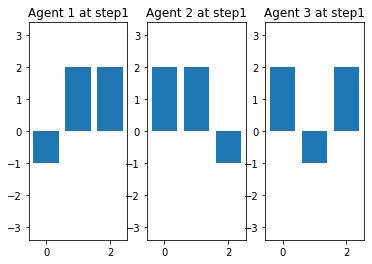

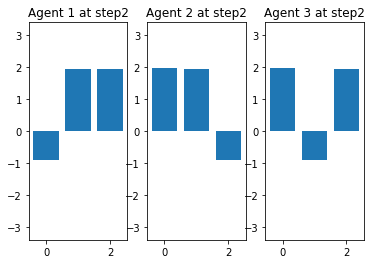

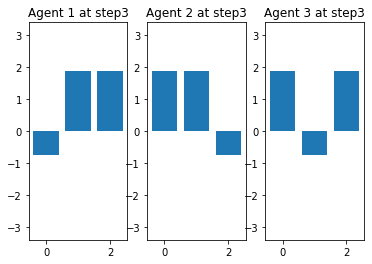

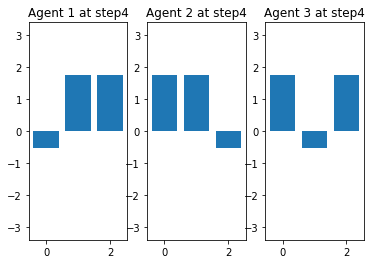

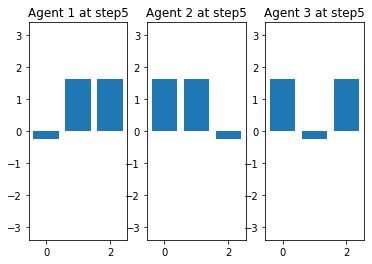

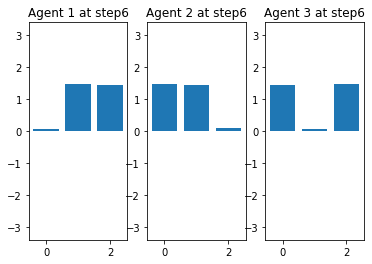

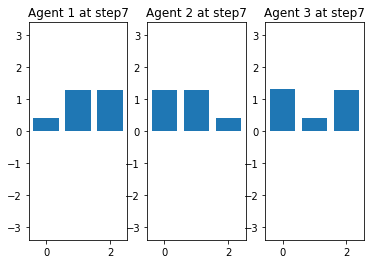

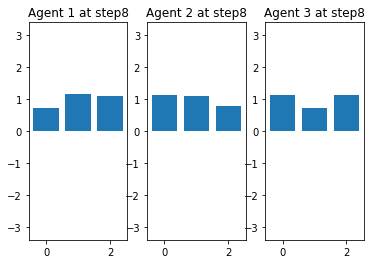

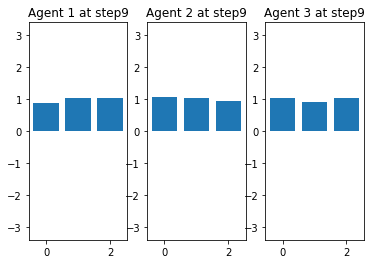

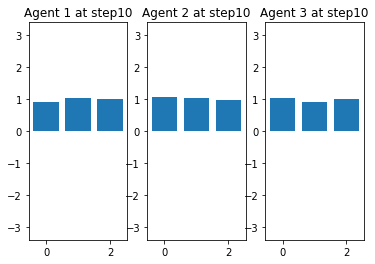

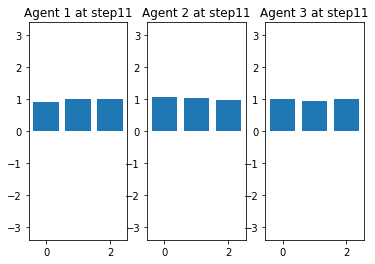

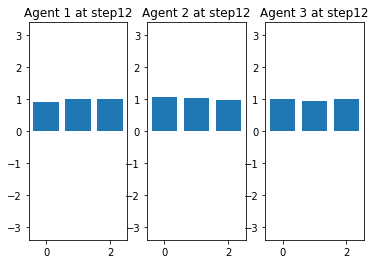

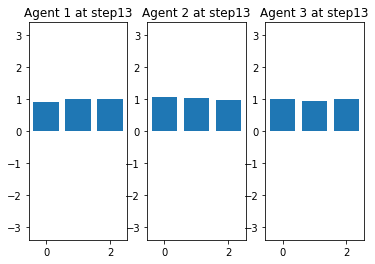

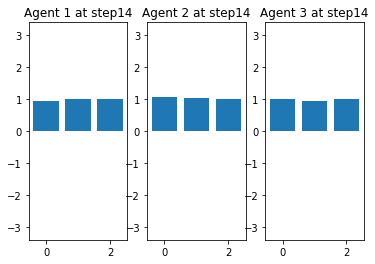

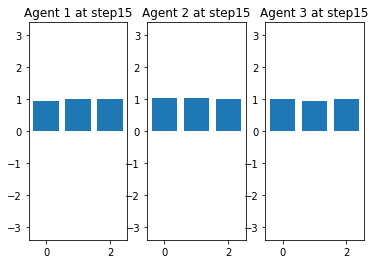

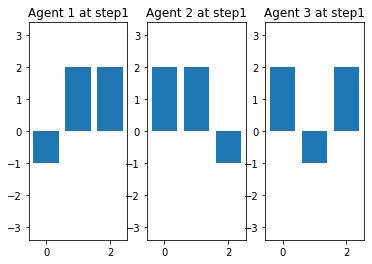

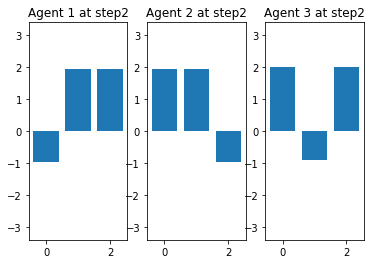

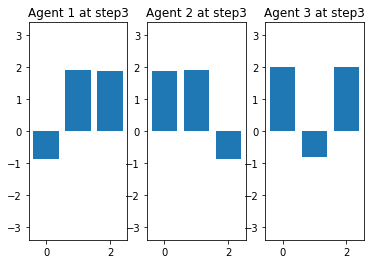

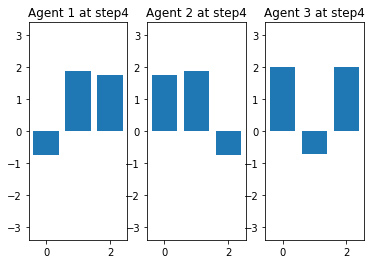

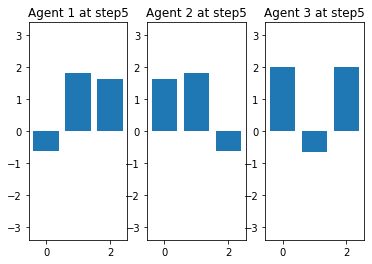

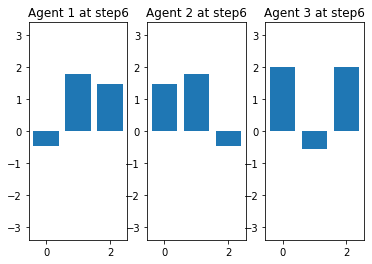

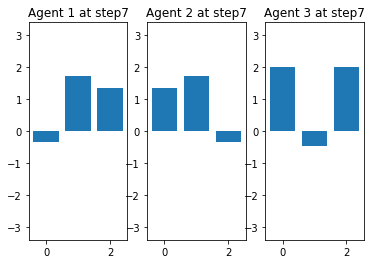

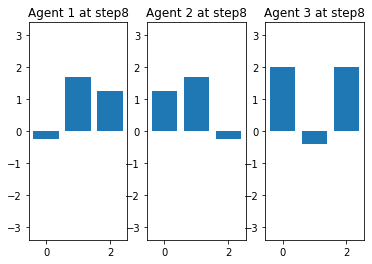

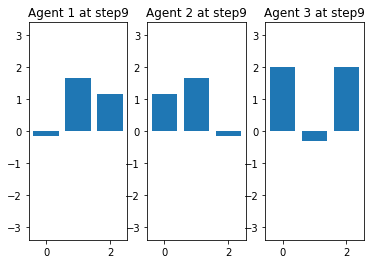

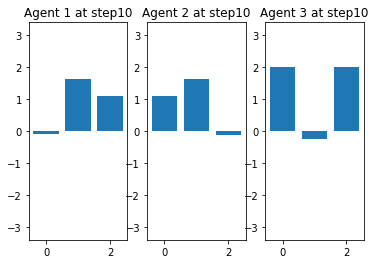

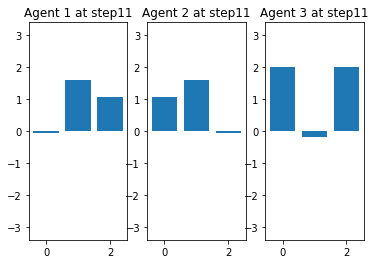

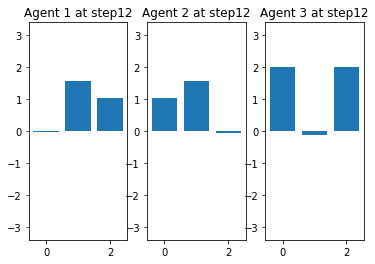

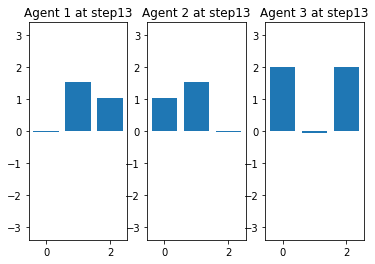

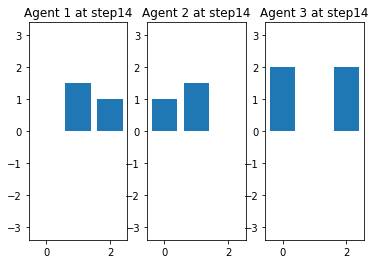

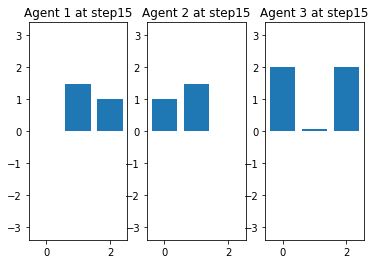

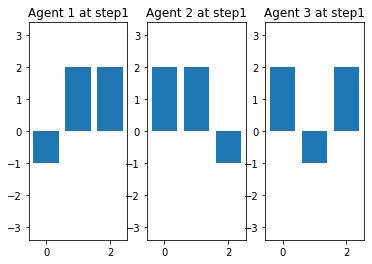

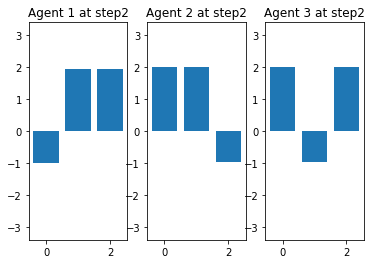

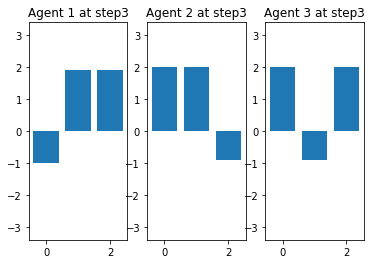

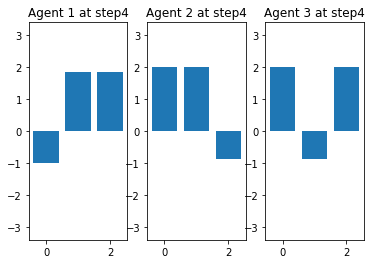

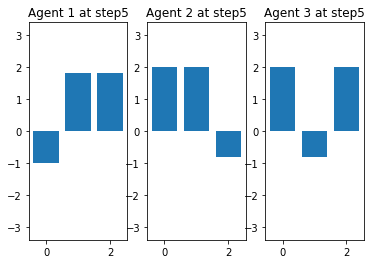

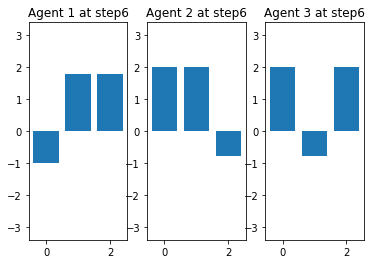

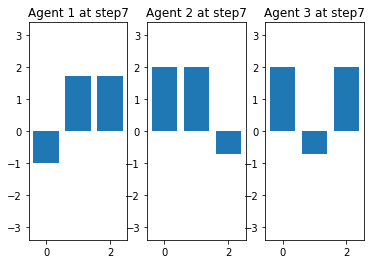

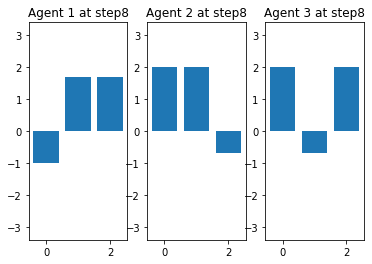

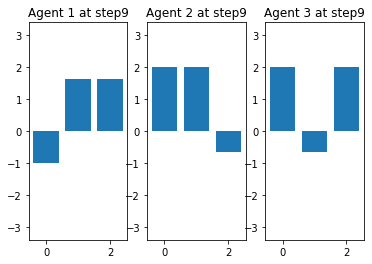

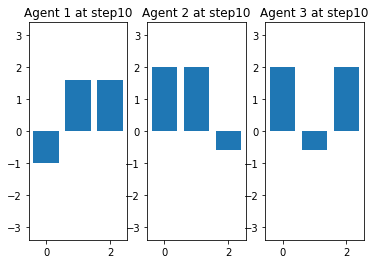

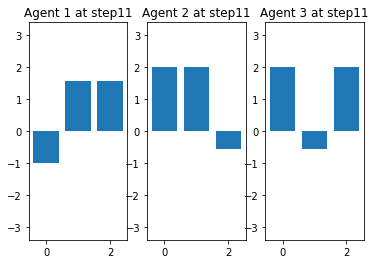

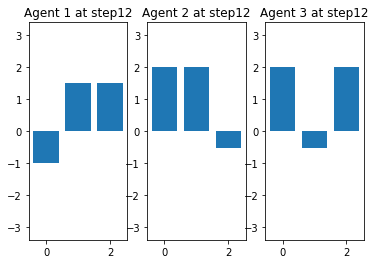

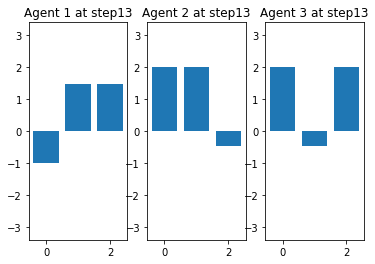

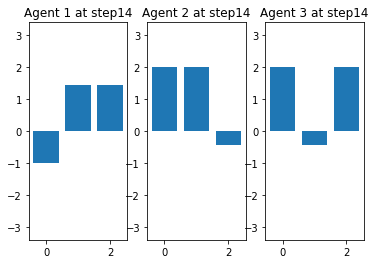

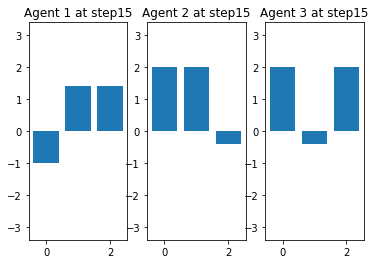

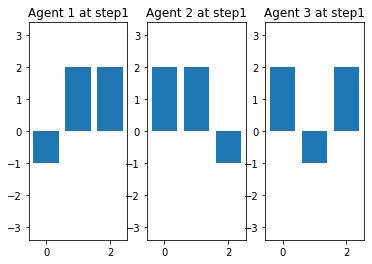

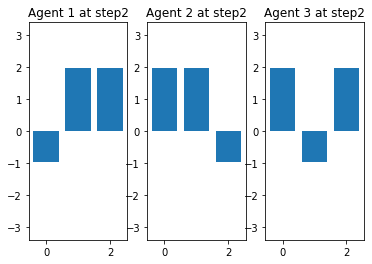

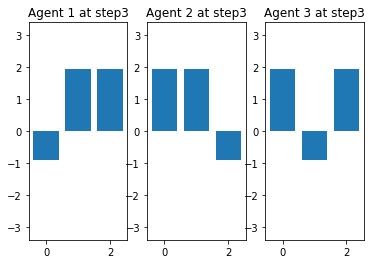

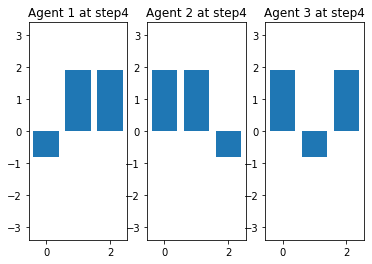

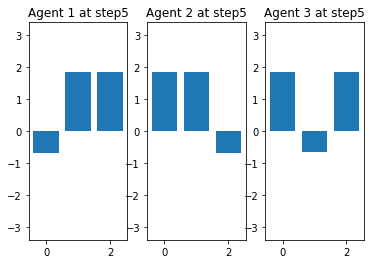

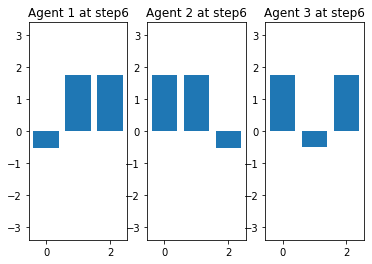

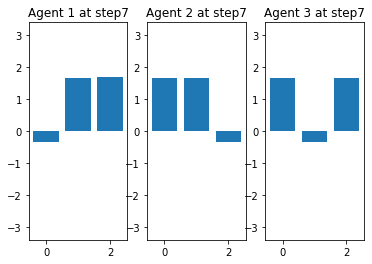

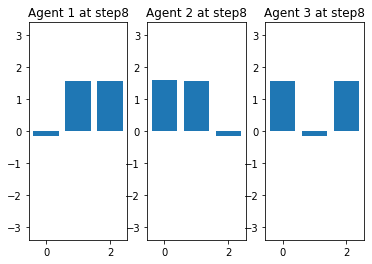

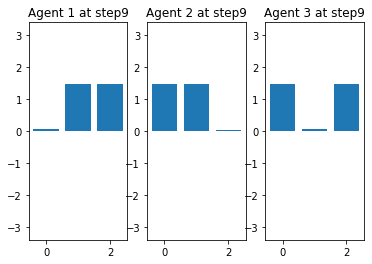

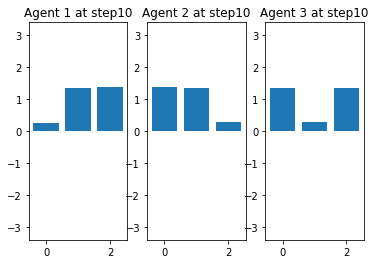

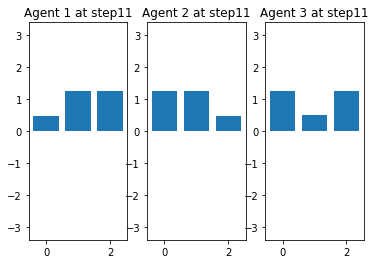

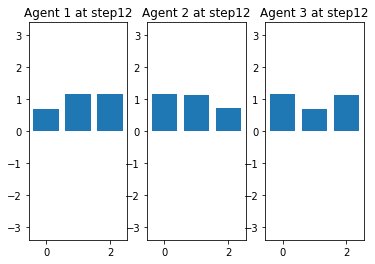

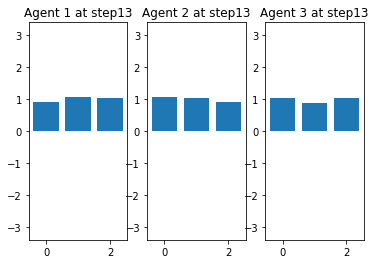

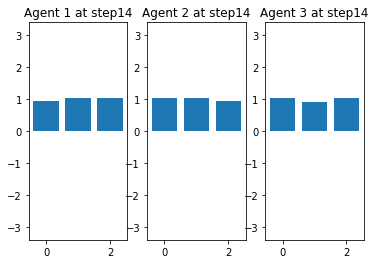

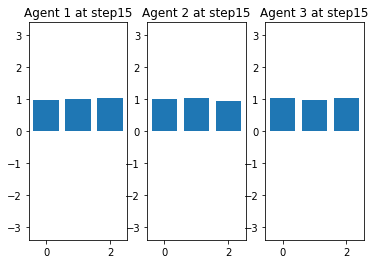

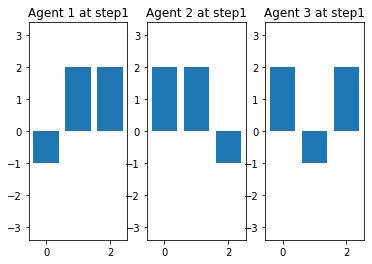

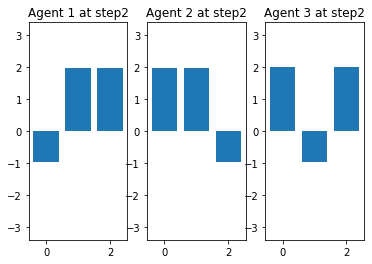

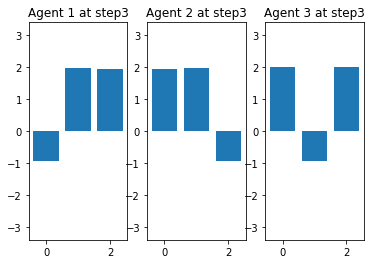

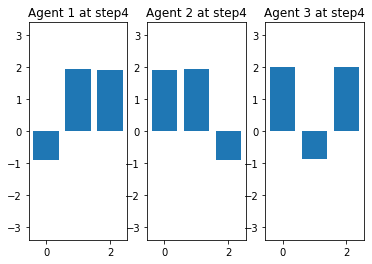

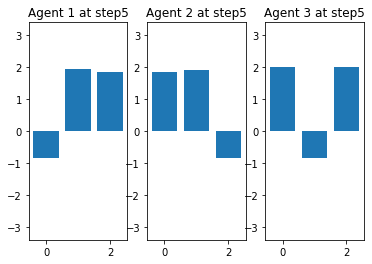

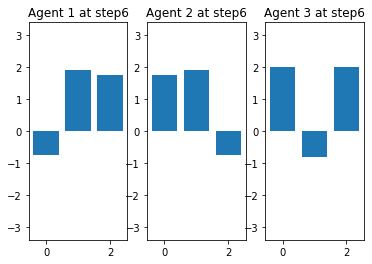

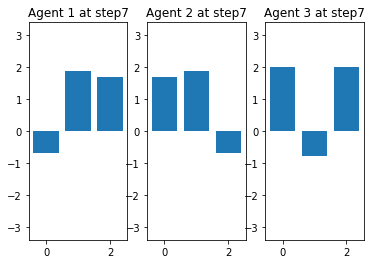

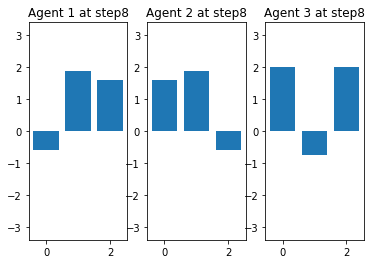

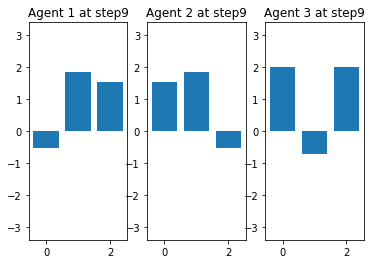

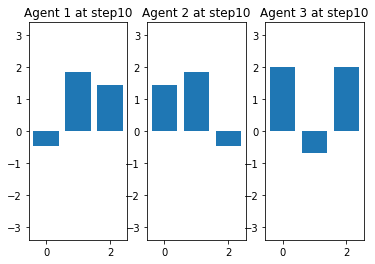

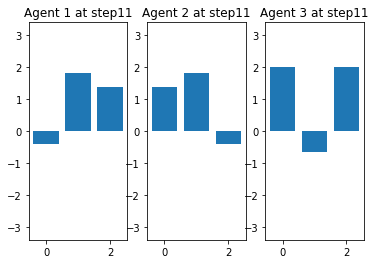

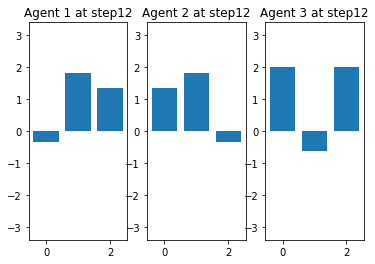

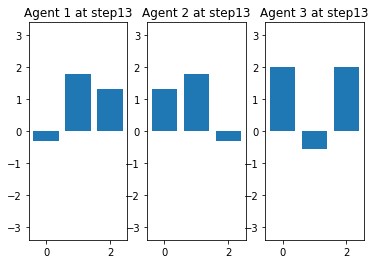

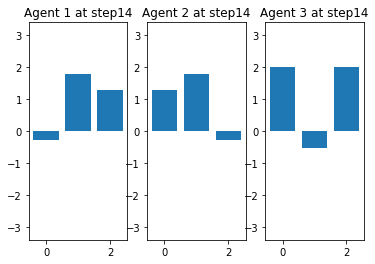

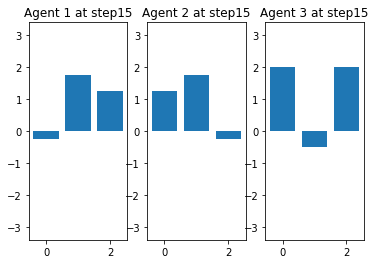

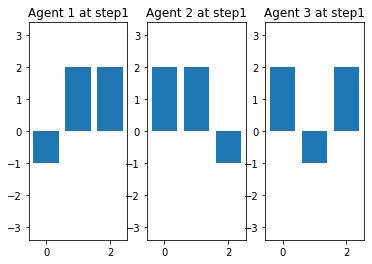

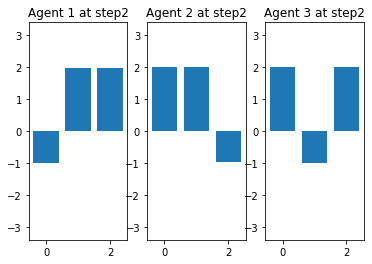

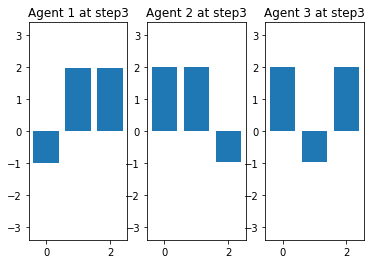

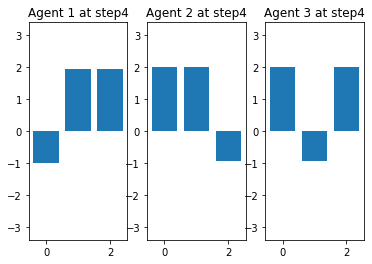

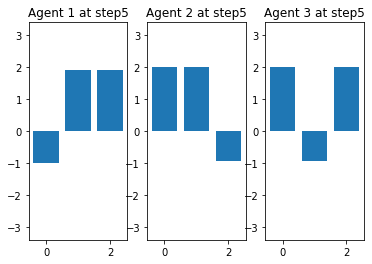

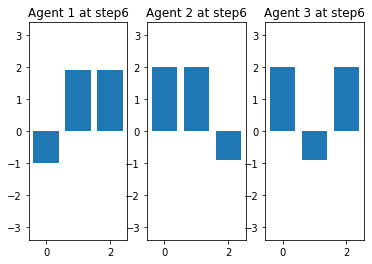

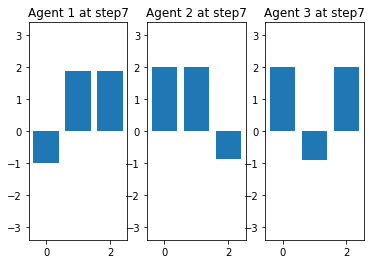

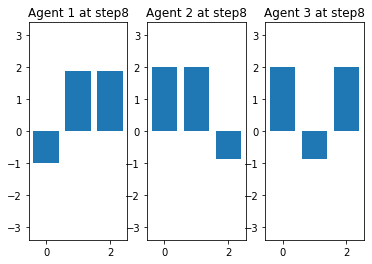

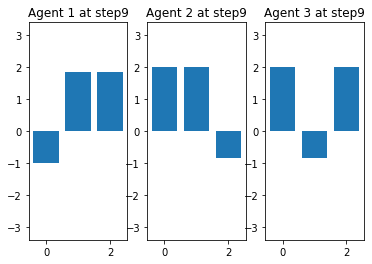

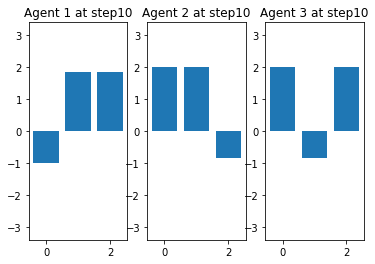

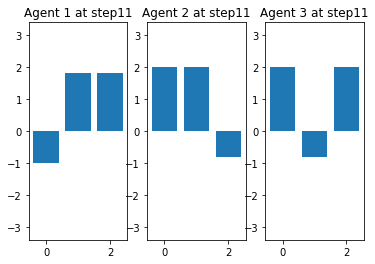

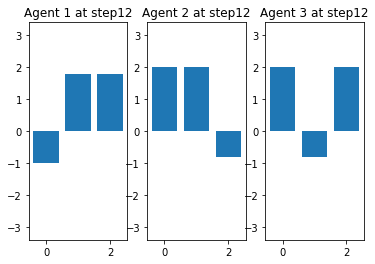

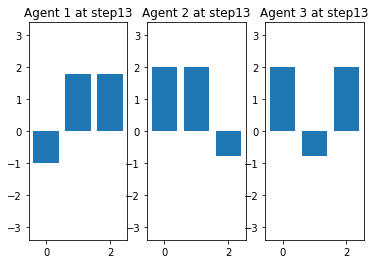

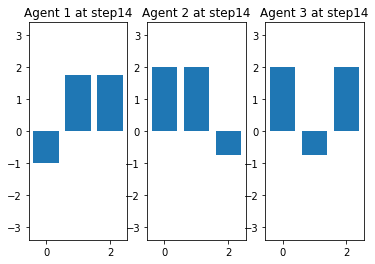

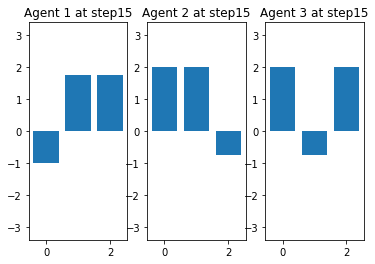

In [27]:
output = do_experiments(experiments)

In [28]:
for x in output:
    param, _, e, sp, utN, ut1E, ut2E, ut3E = x
    print(param, e, sp, ut1E, ut2E)

[0.1, 0.05, 0] 1 0.5958115959498996 3.5035098842748615 2.446246084278225
[0.1, 0.02, 0] 1 0.40550176116633896 3.1706783952886184 2.6393451965131236
